In [20]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
import vvkernels as vvk
import vvmeans as vvm
import vvlikelihood as vvll
from vfield import VField
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
def g_theta(theta):
    return torch.linspace(0, 1, 100)

In [24]:

vf = VField()
loc = np.array([0.2,0.12])
v = vf(loc)
loc1 = np.array([0.2,0.12])
v1 = vf(loc)

x_train = torch.linspace(0, 1, 100)
y_train = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)


class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)
        self.covar_module = vvk.TensorProductKernel(gpytorch.kernels.RBFKernel(), chol_q, num_tasks = 2, rank =1,  task_covar_prior=None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    
#f_target = torch.ones(v.shape[0] * tpk.num_tasks, tpk.num_tasks)



likelihood = vvll.TensorProductLikelihood(x_train, num_tasks = 2)



model = MultitaskGPModel(x_train, y_train, likelihood)

In [25]:
training_iter = 100
model.train()
likelihood.train()



agg_data = y_train


# for param_name, param in model.named_parameters():
#     print(f'Parameter name: {param_name:42}') #' value = {param.item()}')
#     print(param)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

g_theta1 = torch.linspace(0, 1, 100)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(g_theta1)
    loss = -mll(output, agg_data)
    #loss = -likelihood.get_hpll(agg_data, g_theta1, model.mean_module, model.covar_module)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 121.792
Iter 2/100 - Loss: 115.138
Iter 3/100 - Loss: 108.543
Iter 4/100 - Loss: 102.132
Iter 5/100 - Loss: 95.933
Iter 6/100 - Loss: 89.896
Iter 7/100 - Loss: 83.819
Iter 8/100 - Loss: 77.396
Iter 9/100 - Loss: 70.499
Iter 10/100 - Loss: 63.296
Iter 11/100 - Loss: 56.146
Iter 12/100 - Loss: 49.542
Iter 13/100 - Loss: 44.029
Iter 14/100 - Loss: 39.842
Iter 15/100 - Loss: 36.852
Iter 16/100 - Loss: 34.743
Iter 17/100 - Loss: 32.927
Iter 18/100 - Loss: 30.808
Iter 19/100 - Loss: 27.972
Iter 20/100 - Loss: 24.227
Iter 21/100 - Loss: 19.665
Iter 22/100 - Loss: 14.675
Iter 23/100 - Loss: 9.872
Iter 24/100 - Loss: 5.829
Iter 25/100 - Loss: 2.836
Iter 26/100 - Loss: 0.924
Iter 27/100 - Loss: -0.261
Iter 28/100 - Loss: -1.316
Iter 29/100 - Loss: -2.709
Iter 30/100 - Loss: -4.593
Iter 31/100 - Loss: -6.722
Iter 32/100 - Loss: -8.518
Iter 33/100 - Loss: -9.507
Iter 34/100 - Loss: -9.734
Iter 35/100 - Loss: -9.526
Iter 36/100 - Loss: -9.204
Iter 37/100 - Loss: -9.268
Iter 38/10

In [26]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42}') #' value = {param.item()}')
    print(param)

Parameter name: likelihood.task_noise_covar_factor        
Parameter containing:
tensor([[0.0267],
        [0.1410]], requires_grad=True)
Parameter name: likelihood.raw_noise                      
Parameter containing:
tensor([-3.6160], requires_grad=True)
Parameter name: mean_module.base_means.0.constant         
Parameter containing:
tensor([-0.0917], requires_grad=True)
Parameter name: mean_module.base_means.1.constant         
Parameter containing:
tensor([0.4600], requires_grad=True)
Parameter name: covar_module.chol_factor                  
Parameter containing:
tensor([[ 0.9892, -0.0994],
        [ 0.3957,  0.9278]], requires_grad=True)
Parameter name: covar_module.task_covar_module.covar_factor
Parameter containing:
tensor([[-0.9851],
        [-0.6617]], requires_grad=True)
Parameter name: covar_module.task_covar_module.raw_var    
Parameter containing:
tensor([-0.3279, -0.1912], requires_grad=True)
Parameter name: covar_module.data_covar_module.raw_lengthscale
Parameter contai

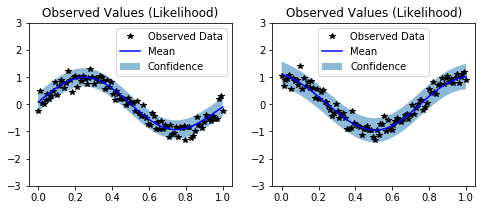

In [27]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [28]:
class param_opti(nn.Module):
    def __init__(self, _theta2):
        super(param_opti, self).__init__()
        self.theta2 = nn.Parameter(_theta2)
        
    def forward(self,k):
        N = self.theta2.shape[0]
        indices = torch.randperm(N)[:k]
        sampled_values = self.theta2[indices]
        return torch.sigmoid(sampled_values)

In [29]:
def conduct_param_opti(x):
    f_target = torch.tensor([np.sqrt(2.)/2., np.sqrt(2.)/2.])
    f_target = f_target.reshape(2,1)
    theta1 = torch.linspace(0, 1, 100)
    agg_data = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

    theta2_0 = torch.linspace(0, 1, 20)
    
    _par = param_opti(theta2_0)
    optimizer = torch.optim.Adam(_par.parameters(), lr=0.1)
    
    for i in range(training_iter):
        optimizer.zero_grad()
        g_theta2 = _par.forward(50)
        loss = -likelihood.get_ell(agg_data,f_target,x, theta1, g_theta2, model.mean_module, model.covar_module)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
    
    return loss

In [31]:
x = Tensor([1./8.])
x = x.reshape(1,1)
conduct_param_opti(x)

torch.Size([40, 40])


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(1,1) is zero, singular U.

In [ ]:
class design_opti(nn.Module):
    def __init__(self, _x):
        super(design_opti, self).__init__()
        self.x_design = nn.Parameter(_x)
        
    def forward(self):
        return self.x_design

In [ ]:
def conduct_design_opti():
    x = Tensor([0.5])
    x = x.reshape(1,1)
    design = design_opti(x)
    optimizer = torch.optim.Adam(design.parameters(), lr=0.1)
    for i in range(training_iter):
        optimizer.zero_grad()
        x = design.forward()
        loss = conduct_param_opti(x)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
    
    
    